# High Dynamic Range (HDR)

<div style="display: flex; justify-content: space-between;">
    <img src="datos/HighDynamicRange/image4.png" style="width: 48%;"/>
    <img src="datos/HighDynamicRange/Saved/ldr-Reinhard.jpg" style="width: 48%;"/>
</div>

## Import the libraries

In [1]:
# Import Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Basic Idea

1. The **dynamic range** of images is limited to 8-bits (0 - 255) per channel
2. Very bright pixels saturate to 255
3. Very dark pixels clip to 0

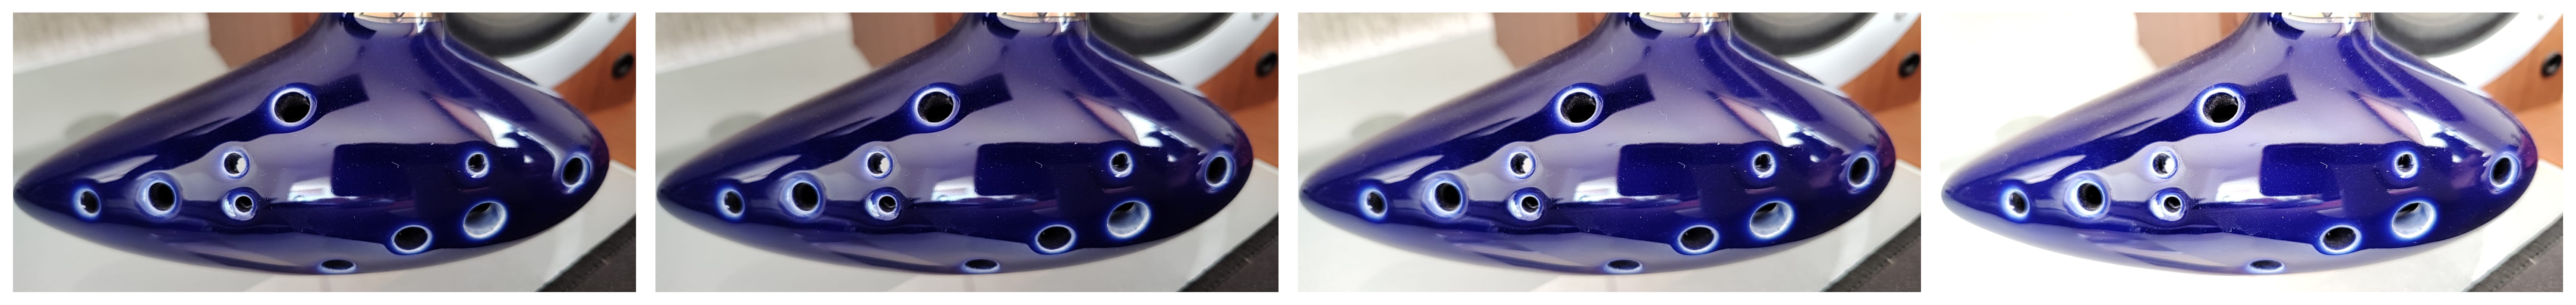

## Capture Multiple Exposures

In [2]:
def readImagesAndTimes():
    # List of file names
    filenames = ["datos/HighDynamicRange/image1.png", "datos/HighDynamicRange/image2.png", "datos/HighDynamicRange/image3.png", "datos/HighDynamicRange/image4.png"]
    
    # List of exposure times
    times = np.array([0.33, 0.5, 1, 2], dtype=np.float32)

    # Read images
    images = []
    for filename in filenames:
        im = cv2.imread(filename)
        images.append(im)

    return images, times

## Align Images

In [3]:
# Read images and exposure times
images, times = readImagesAndTimes()

# Align Images
alignMTB = cv2.createAlignMTB()
alignMTB.process(images, images)

## Estimate Camera Response Function

### What is the Camera Response Function (CRF)?
The Camera Response Function (CRF) describes how a camera converts real-world light intensity into digital pixel values. This function is specific to each camera and can vary depending on factors such as:

Sensor sensitivity.
White balance settings.
Gamma correction or compression applied by the camera.
In simple terms, the CRF maps the measured pixel values (e.g., 0–255) to the actual light intensity captured by the camera. This mapping is crucial for tasks like:

Exposure fusion (HDR) : Combining multiple images with different exposures to create an HDR image.
Camera calibration : Understanding how the camera interprets light to correct errors or improve image quality.

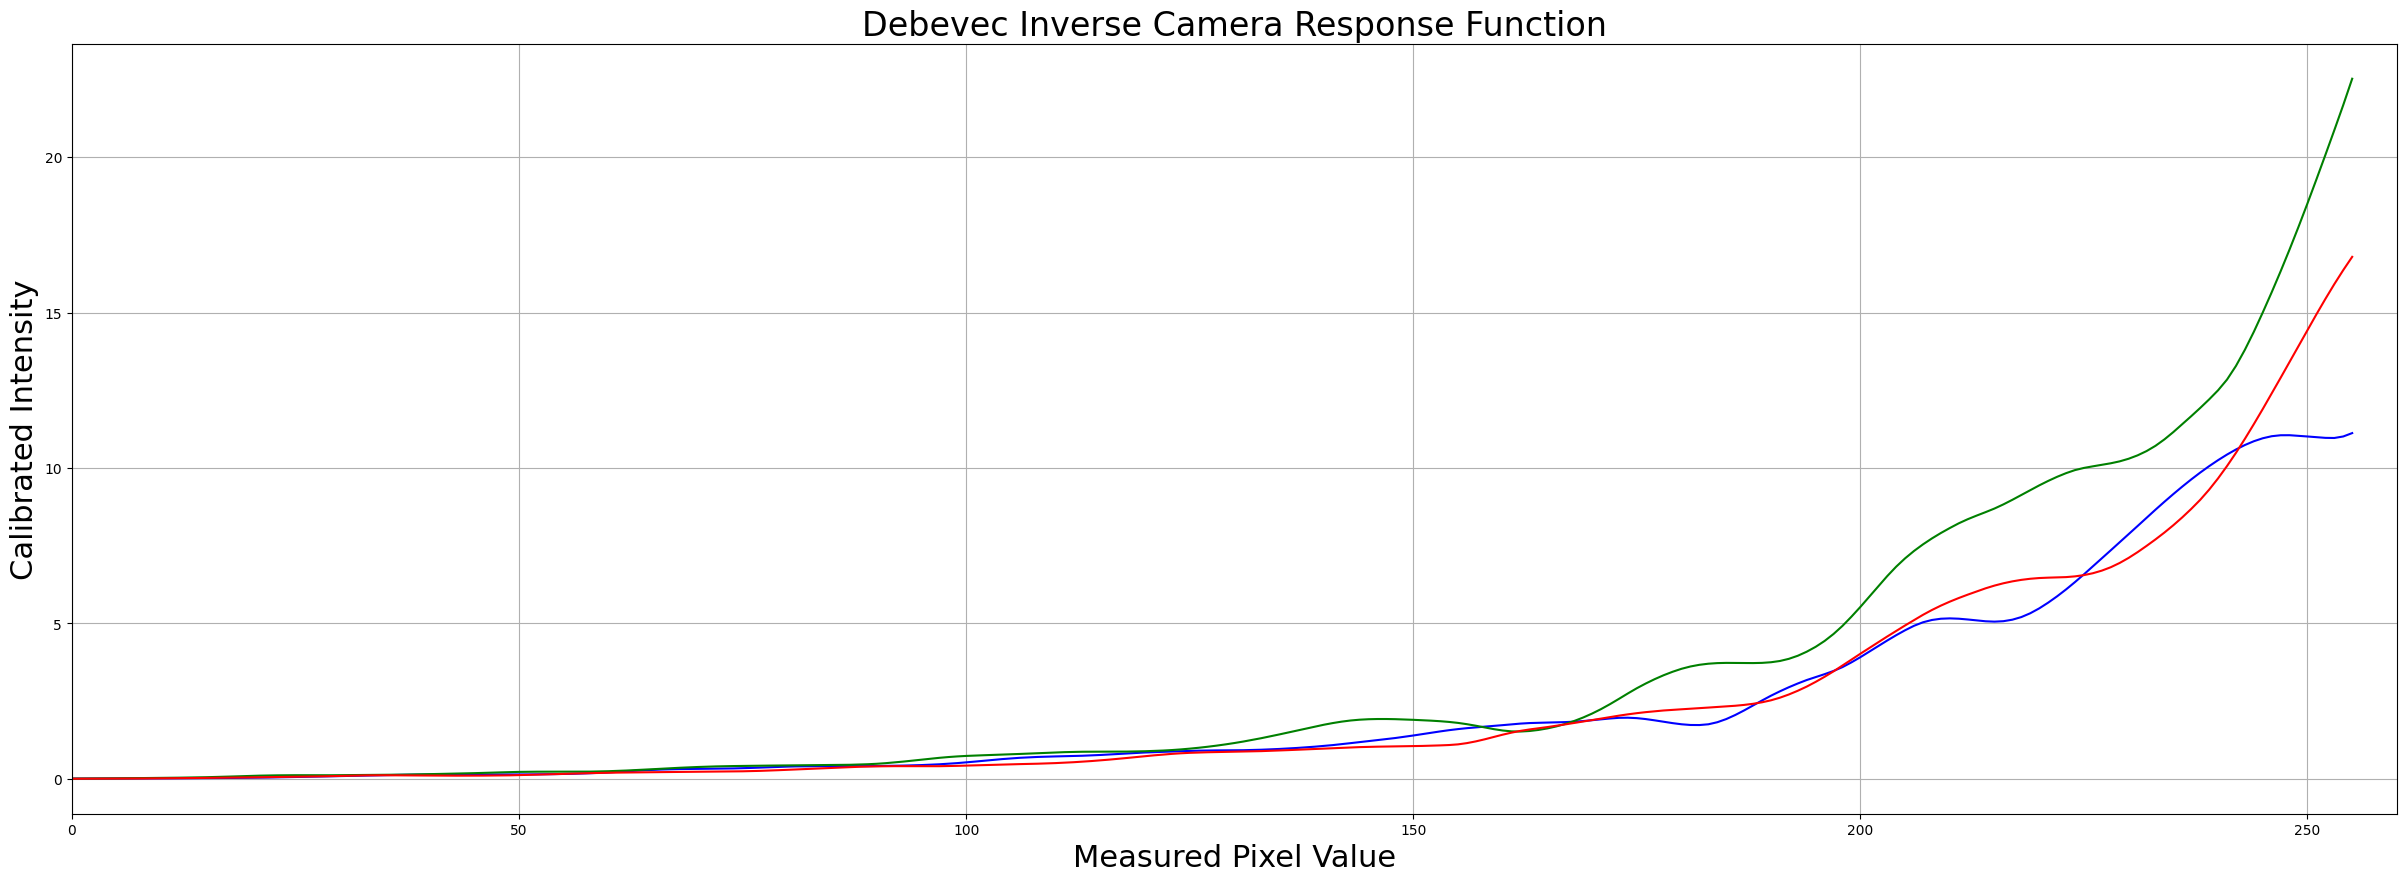

In [4]:
# Find Camera Response Function (CRF)
calibrateDebevec = cv2.createCalibrateDebevec()
responseDebevec = calibrateDebevec.process(images, times)

# Plot CRF
x = np.arange(256, dtype=np.uint8)
y = np.squeeze(responseDebevec)

ax = plt.figure(figsize=(30, 10))
plt.title("Debevec Inverse Camera Response Function", fontsize=24)
plt.xlabel("Measured Pixel Value", fontsize=22)
plt.ylabel("Calibrated Intensity", fontsize=22)
plt.xlim([0, 260])
plt.grid()
plt.plot(x, y[:, 0], "b", x, y[:, 1], "g", x, y[:, 2], "r")

## Merge Exposure into an HDR Image

In [5]:
# Merge images into an HDR linear image
mergeDebevec = cv2.createMergeDebevec()
hdrDebevec = mergeDebevec.process(images, times, responseDebevec)

## Tonemapping

Many Tonemapping algorithms are available in OpenCV. We chose Drago as it has more controls.

[ WARN:0@0.957] global matrix_expressions.cpp:1334 assign OpenCV/MatExpr: processing of multi-channel arrays might be changed in the future: https://github.com/opencv/opencv/issues/16739
[ WARN:0@0.985] global loadsave.cpp:848 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.


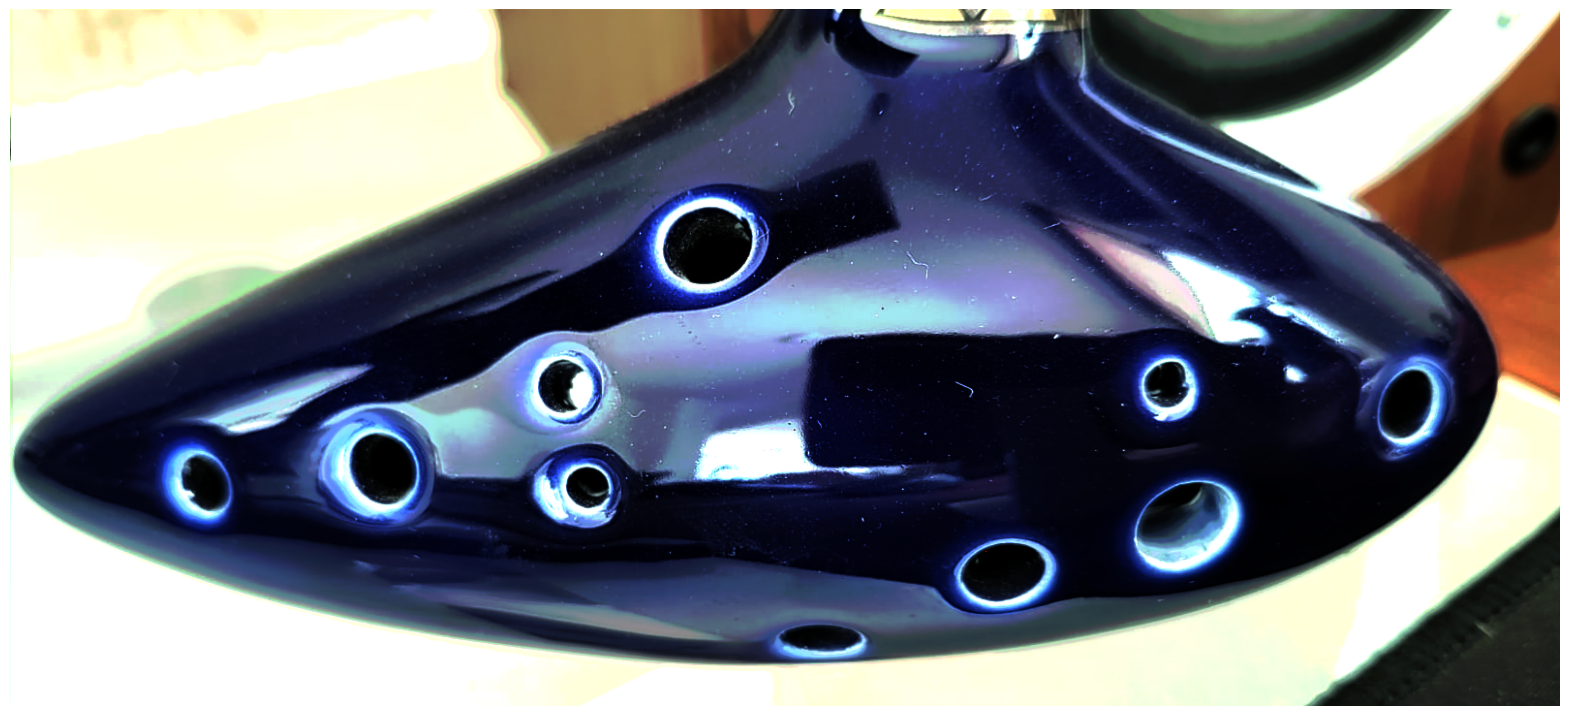

In [6]:
# Tonemap using Drago's method to obtain 24-bit color image
tonemapDrago = cv2.createTonemapDrago(0.7, 0.5)
ldrDrago = tonemapDrago.process(hdrDebevec)
ldrDrago = 3 * ldrDrago

# Saving image
cv2.imwrite("datos/HighDynamicRange/Saved/ldr-Drago.jpg", 255*ldrDrago)

# Plotting image
plt.figure(figsize=(20, 10));plt.imshow(np.clip(ldrDrago, 0, 1)[:,:,::-1]);plt.axis("off");

Tonemaping using Reinhard's method ... 


(np.float64(-0.5), np.float64(1599.5), np.float64(718.5), np.float64(-0.5))

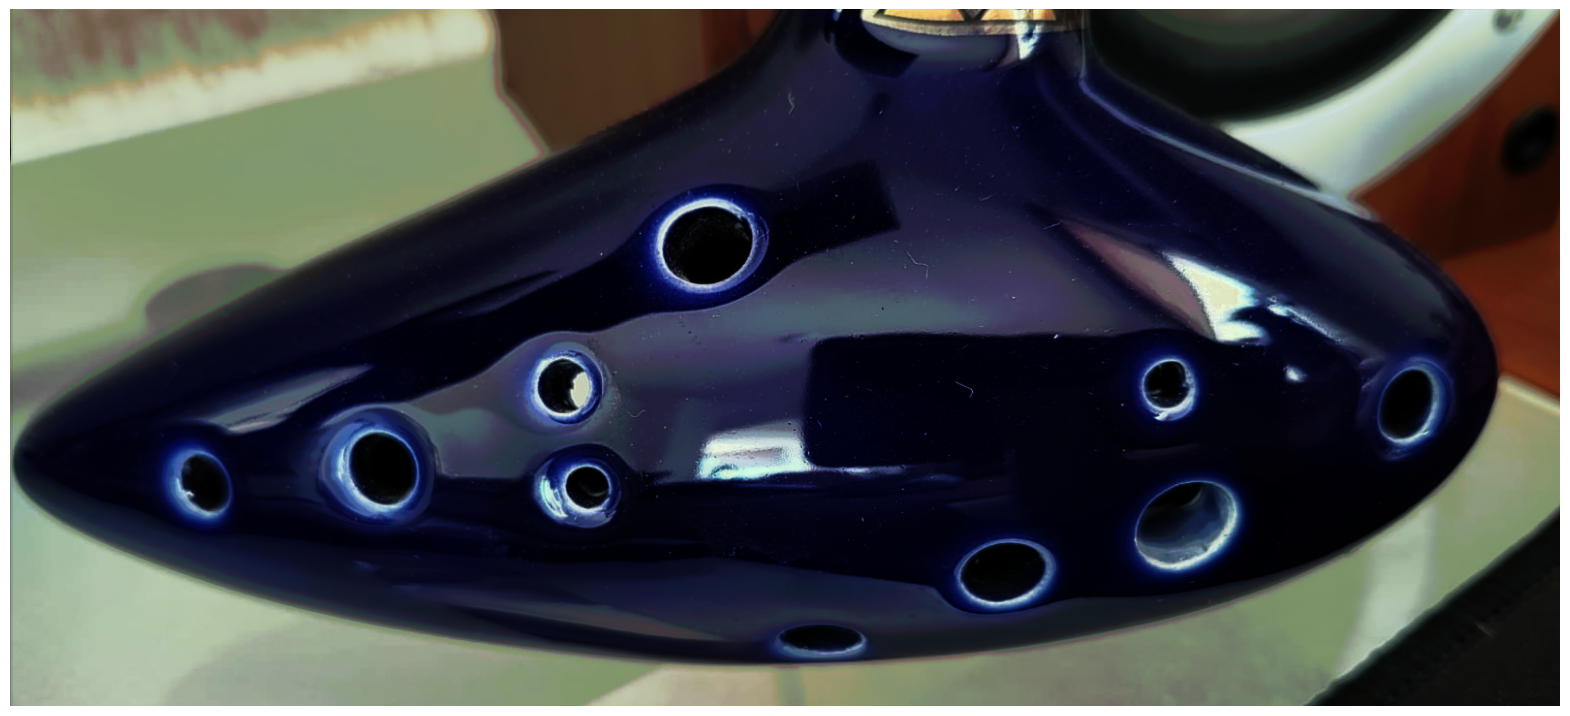

In [7]:
# Tonemap using Reinhard's method to obtain 24-bit color image
print("Tonemaping using Reinhard's method ... ")
tonemapReinhard = cv2.createTonemapReinhard(1, 1, 0, 1)
ldrReinhard = tonemapReinhard.process(hdrDebevec)

# Saving image
cv2.imwrite("datos/HighDynamicRange/Saved/ldr-Reinhard.jpg", ldrReinhard * 255)

# Plotting image
plt.figure(figsize=(20, 10));plt.imshow(np.clip(ldrReinhard, 0, 1)[:,:,::-1]);plt.axis("off")

## Why Does Reinhard Look "Best"?

- Reinhard tone-mapping produces images that look visually natural . It mimics how the human visual system perceives brightness and adapts to different lighting conditions. For example:
- It avoids overexposing bright areas (like skies or light sources).
- It preserves details in shadows without making them overly dark.
- This makes the output image feel more like what the human eye would perceive in real life, which is often preferred over other methods that may introduce artificial artifacts.

Tonemaping using Mantiuk's method ... 


(np.float64(-0.5), np.float64(1599.5), np.float64(718.5), np.float64(-0.5))

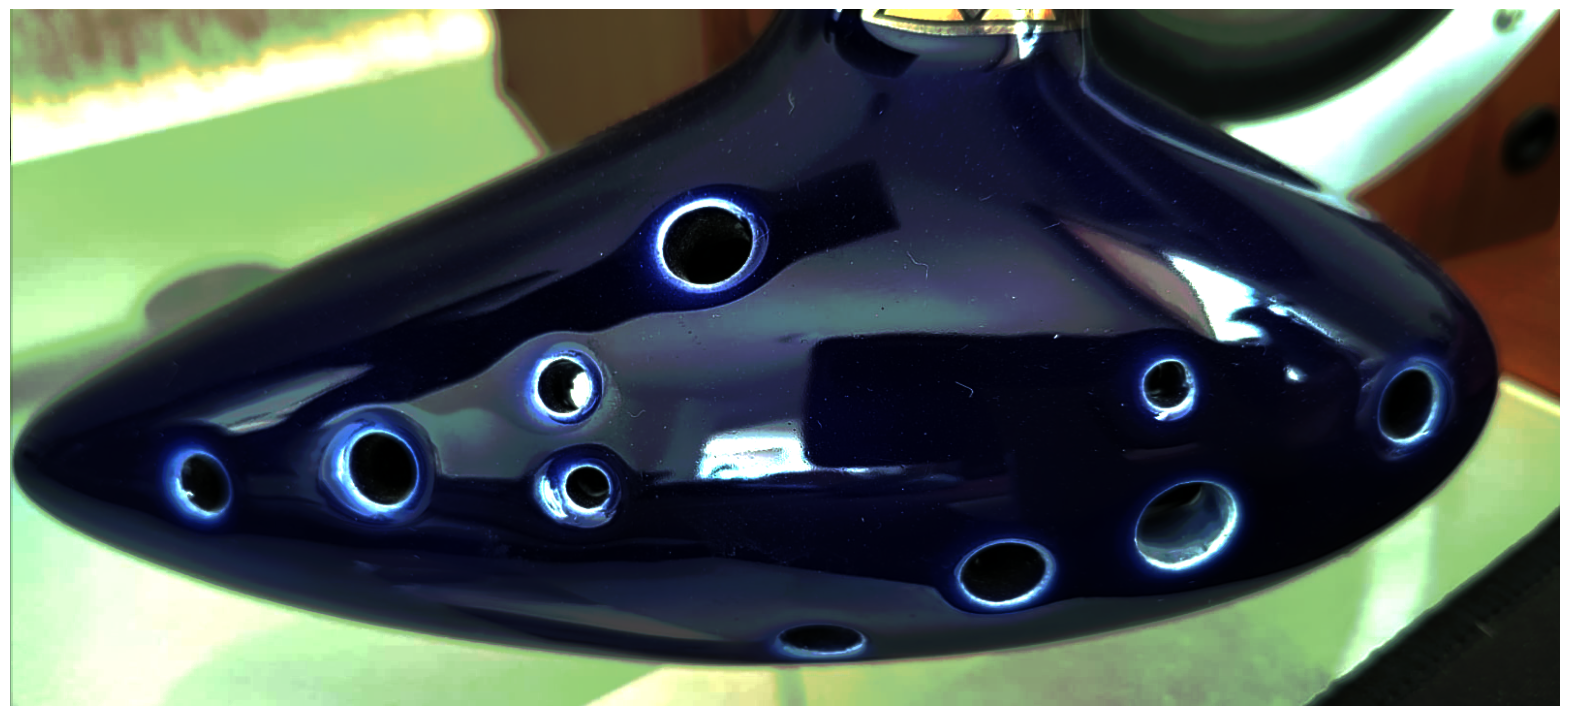

In [8]:
# Tonemap using Mantiuk's method to obtain 24-bit color image
print("Tonemaping using Mantiuk's method ... ")
tonemapMantiuk = cv2.createTonemapMantiuk(1.3, 1, 1)
ldrMantiuk = tonemapMantiuk.process(hdrDebevec)
ldrMantiuk = 3 * ldrMantiuk

# save the image using cv2.imwrite
cv2.imwrite("datos/HighDynamicRange/Saved/ldr-Mantiuk.jpg", ldrMantiuk * 255)

# plot the image using plt.imshow
plt.figure(figsize=(20, 10));plt.imshow(np.clip(ldrMantiuk, 0, 1)[:,:,::-1]);plt.axis("off")